## Neural Network and Data Mining

A project that demonstrates construction, use, and evaluation of a neural network and the sourcing and cleaning of a dataset.

First we load the libraries we'll need. The dataset is initially formatted as an SQL databse, so we need sqlite3 to read it initially and then use pandas to translate it into a dataframe.

In [1]:
import numpy as np
import pandas as pd
import datetime
import sqlite3
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The data is taken from a Kaggle competition page linked here.

In [3]:
db = sqlite3.connect("/content/gdrive/My Drive/Datasets/database.sqlite")

#Seasons 2008-2016
#https://www.kaggle.com/datasets/hugomathien/soccer

Read each of the databases into separate dataframes with pandas. They all have different columns so we will work on combining their relevant information later.

In [4]:
matches = pd.read_sql("SELECT * from Match", db)
country = pd.read_sql("SELECT * from Country", db)
league = pd.read_sql("SELECT * from League", db)
player = pd.read_sql("SELECT * from Player", db)
playerAttributes = pd.read_sql("SELECT * from Player_Attributes", db)
team = pd.read_sql("SELECT * from Team", db)
teamAttributes = pd.read_sql("SELECT * from Team_Attributes", db)

Let's see which leagues we have data for.

In [5]:
league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


Great! All of these leagues are in Europe. Soccer seasons in Europe begin in August and end in May, and thus, since teams and players are graded on a season by season basis, we should have a feature that gives the season in which a match occurred. We have the date for each match and a date corresponding to player attributes. There are some player attribute dates that are before the first season of interest (before August, 2008) or after the last season (after May, 2016). We won't add a season to those rows, and then we will remove them from the dataset by comparing any dates from those years to the earliest and latest match dates respectively.

In [6]:
df = pd.to_datetime(playerAttributes['date'])

low = pd.to_datetime(matches['date'].min())
high = pd.to_datetime(matches['date'].max())

seasons = []

for i in range(len(df)):
  if (df[i] > low) & (df[i].strftime('%Y') == '2008'):
    seasons.append('2008/2009')
  if (df[i].month <= 6) & (df[i].strftime('%Y') == '2009'):
    seasons.append('2008/2009')
  if (df[i].month > 6) & (df[i].strftime('%Y') == '2009'):
    seasons.append('2009/2010')
  if (df[i].month <= 6) & (df[i].strftime('%Y') == '2010'):
    seasons.append('2009/2010')
  if (df[i].month > 6) & (df[i].strftime('%Y') == '2010'):
    seasons.append('2010/2011')
  if (df[i].month <= 6) & (df[i].strftime('%Y') == '2011'):
    seasons.append('2010/2011')
  if (df[i].month > 6) & (df[i].strftime('%Y') == '2011'):
    seasons.append('2011/2012')
  if (df[i].month <= 6) & (df[i].strftime('%Y') == '2012'):
    seasons.append('2011/2012')
  if (df[i].month > 6) & (df[i].strftime('%Y') == '2012'):
    seasons.append('2012/2013')
  if (df[i].month <= 6) & (df[i].strftime('%Y') == '2013'):
    seasons.append('2012/2013')
  if (df[i].month > 6) & (df[i].strftime('%Y') == '2013'):
    seasons.append('2013/2014')
  if (df[i].month <= 6) & (df[i].strftime('%Y') == '2014'):
    seasons.append('2013/2014')
  if (df[i].month > 6) & (df[i].strftime('%Y') == '2014'):
    seasons.append('2014/2015')
  if (df[i].month <= 6) & (df[i].strftime('%Y') == '2015'):
    seasons.append('2014/2015')
  if (df[i].month > 6) & (df[i].strftime('%Y') == '2015'):
    seasons.append('2015/2016')
  if (df[i] < high) & (df[i].strftime('%Y') == '2016'):
    seasons.append('2015/2016')

In [7]:
badDates = []
low = matches['date'].min()
high = matches['date'].max()


for i in range(len(playerAttributes)):
  if playerAttributes['date'][i] < low:
    badDates.append(i)
  if playerAttributes['date'][i] > high:
    badDates.append(i)

A little ugly, but it worked! Now we know the season for which the player attriutes apply, and removed any rows that don't match our target dataset. This will be important later for matching other data points to each player and match.

Let's double check to make sure the length of the player attribute dataset is the same as the seasons list we just made, so that they match up when we combine them.

In [8]:
(len(playerAttributes)-len(badDates)) - len(seasons)

0

Perfect. Now let's take these rows out of the player attribute dataset and consolidate it with the seasons feature we just created.

In [9]:
playerAttributes = playerAttributes.drop(badDates)
playerAttributes['season'] = seasons
playerAttributes = playerAttributes.drop_duplicates(subset=['player_api_id', 'season'], keep='first')
playerAttributes.reset_index(drop=True, inplace=True)

Now let's assess the state of the dataset in terms of N/A or null values. To do that, we'll use a quick one liner that shows how many null values there are in each column.

In [10]:
playerAttributes.isna().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating            0
potential                 0
preferred_foot            0
attacking_work_rate    1006
defensive_work_rate       0
crossing                  0
finishing                 0
heading_accuracy          0
short_passing             0
volleys                 716
dribbling                 0
curve                   716
free_kick_accuracy        0
long_passing              0
ball_control              0
acceleration              0
sprint_speed              0
agility                 716
reactions                 0
balance                 716
shot_power                0
jumping                 716
stamina                   0
strength                  0
long_shots                0
aggression                0
interceptions             0
positioning               0
vision                  716
penalties                 0
marking                   0
standing_tackle     

There are several columns that are missing a significant number of values, but we have enough columns that in my opinion, looking at which columns have the null values, it is better to work around these columns than to drop that many rows of data. This is especially true if there isn't overlap between which rows are missing values in each column. It is important to check for null values so that later, when we select the features to use in our model, we know not to include those which are incomplete.

Now let's add the position of each player to their player attribute row. We'll do this by using the attributes "GK Handling", "Short Passing", "Standing Tackle", and "Finishing" as proxies for the positions of goalkeeper, midfielder, defender, and attacker respectively. Whichever of these attributes is the player's highest will correspond to the position we ascribe them.

In [11]:
positions = []

for i in range(len(playerAttributes)):
  if playerAttributes['gk_handling'][i] > 60:
    positions.append('G')
    continue
  if max(playerAttributes['finishing'][i], playerAttributes['short_passing'][i], playerAttributes['standing_tackle'][i]) == playerAttributes['finishing'][i]:
    positions.append('A')
    continue
  if max(playerAttributes['finishing'][i], playerAttributes['short_passing'][i], playerAttributes['standing_tackle'][i]) == playerAttributes['standing_tackle'][i]:
    positions.append('D')
    continue
  if max(playerAttributes['finishing'][i], playerAttributes['short_passing'][i], playerAttributes['standing_tackle'][i]) == playerAttributes['short_passing'][i]:
    positions.append('M')
    continue
  else:
    print(playerAttributes['finishing'][i], playerAttributes['short_passing'][i], playerAttributes['standing_tackle'][i])



playerAttributes['position'] = positions

At this point, the dataset is fairly large, and correlation of certain features to success may not carry across leagues. Since I just have my CPU to run on, and the primary goal is to make something successful, we're going to take a subset of the data that only includes matches from the English Premier League that don't have an outright favorite. First we'll extract the EPL matches.

In [12]:
matchesEPL = matches[matches['league_id'] == 1729]
matchesEPL.reset_index(drop=True, inplace=True)

To effectively compare teams in order to predict the outcome of a match, we have to be able to compare the squads of players themselves in some capacity. To do this, we will assemble the squads by assigning each player a team. We have to do this by season since teams can acquire new players and players can change teams.

First we isolate the players. Since every team will be the home team at some point, we only need the home team players columns. Then we'll take these 11 columns and stack them to make one column.

In [13]:
squads = matchesEPL[['home_player_1', 'home_player_2', 'home_player_3',
       'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7',
       'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11']]

squadsLong = squads.stack([0],dropna=False)

squadsLong.shape

(33440,)

From there, we're going to get the index of each player, the club they play for, and the season for which that index corresponds. We grab the match ID by taking the modulo 11, since the first 11 players will be in the first game, the second 11 in the second game, etc.

We append the index of the player to an empty list, then grab the club name by indexing the matches dataset with the match ID, as well as the season.

At the end, we consolidate these three lists into a separate dataset and merge it with the player attributes dataset we've been working with. We are able to accurately merge it using ID and season, ultimately adding just the team to which the player belonged that season.

In [100]:
id = []
clubs = []
years = []

modulo = 11
x = 0.1

for i in range(len(squadsLong)):
  if squadsLong.iloc[i] == 'nan':
    continue
  else:
    id.append(squadsLong.iloc[i])
  if i%modulo == 0:
    matchID = np.floor(i/modulo) - 1 #edge case we have to subtract 1
  if i == 0:
    matchID = 0
  else:
    matchID = np.floor(i/modulo)
  club = matchesEPL['home_team_api_id'][matchID]
  year = matchesEPL['season'][matchID]

  clubs.append(club)
  years.append(year)


  if i > len(squadsLong)*x:
      print(str(100*x) + " % done")
      x += 0.1

10.0 % done
20.0 % done
30.000000000000004 % done
40.0 % done
50.0 % done
60.0 % done
70.0 % done
80.0 % done
89.99999999999999 % done


In [15]:
clubID = pd.DataFrame(data= {'player_api_id':id, 'team':clubs, 'season':years})

In [16]:
playerTeams = playerAttributes.merge(clubID, how='left', on=['player_api_id', 'season'])

We do have some null values to deal with; we had to leave them in so that the modulo strategy worked, but now we will remove them. These rows represent individual players during particular seasons. Removing them will mean they are not incorporated into the team's average values later, but is necessary in order to move forward.

In [17]:
drops = []

for i in range(len(playerTeams)):
  if pd.isna(playerTeams['team'][i]) == True:
    drops.append(i)

playerTeamsEPL = playerTeams.drop(drops)
playerTeamsEPL.reset_index(drop=True, inplace=True)

Double check to make sure everything went as planned.

In [18]:
len(playerTeams) - playerTeams['team'].isna().sum() == len(playerTeamsEPL)

True

Excellent, our data is really starting to take shape! Now we can merge the player dataset from earlier and begin aggregating some of the attribute data.

Someone (or many people) will hate this, but I encourage you to think of it as an opportunity for me to learn! While it may be tough to look at, these lists and the nested for-loop eventually hand us the average speed, height, and rating of each position for each team each year. Since we pared down the dataset, this inefficiency isn't as egregious as it might be in other situations. I'm willing to sacrifice the runtime for effective results at this moment.

In [19]:
playerTeamsEPL = playerTeamsEPL.merge(player, how='left', on=['player_api_id'])

In [20]:
t = []
y = []
r = []
h_a = []
h_m = []
h_d = []
s_a = []
s_m = []
s_d = []
a_r = []
m_r = []
d_r = []

for club in set(playerTeamsEPL['team']):
  for year in set(playerTeamsEPL['season']):
    t.append(club)
    y.append(year)

    rtg = np.mean(playerTeamsEPL['overall_rating'][(playerTeamsEPL['team'] == club) & (playerTeamsEPL['season'] == year)])
    hgt_a = np.mean(playerTeamsEPL['height'][(playerTeamsEPL['team'] == club) & (playerTeamsEPL['season'] == year) & (playerTeamsEPL['position'] == 'A')])
    hgt_m = np.mean(playerTeamsEPL['height'][(playerTeamsEPL['team'] == club) & (playerTeamsEPL['season'] == year) & (playerTeamsEPL['position'] == 'M')])
    hgt_d = np.mean(playerTeamsEPL['height'][(playerTeamsEPL['team'] == club) & (playerTeamsEPL['season'] == year) & (playerTeamsEPL['position'] == 'D')])
    spd_a = np.mean(playerTeamsEPL['sprint_speed'][(playerTeamsEPL['team'] == club) & (playerTeamsEPL['season'] == year) & (playerTeamsEPL['position'] == 'A')])
    spd_m = np.mean(playerTeamsEPL['sprint_speed'][(playerTeamsEPL['team'] == club) & (playerTeamsEPL['season'] == year) & (playerTeamsEPL['position'] == 'M')])
    spd_d = np.mean(playerTeamsEPL['sprint_speed'][(playerTeamsEPL['team'] == club) & (playerTeamsEPL['season'] == year) & (playerTeamsEPL['position'] == 'D')])
    rtg_a = np.mean(playerTeamsEPL['overall_rating'][(playerTeamsEPL['team'] == club) & (playerTeamsEPL['season'] == year) & (playerTeamsEPL['position'] == 'A')])
    rtg_m = np.mean(playerTeamsEPL['overall_rating'][(playerTeamsEPL['team'] == club) & (playerTeamsEPL['season'] == year) & (playerTeamsEPL['position'] == 'M')])
    rtg_d = np.mean(playerTeamsEPL['overall_rating'][(playerTeamsEPL['team'] == club) & (playerTeamsEPL['season'] == year) & (playerTeamsEPL['position'] == 'D')])



    r.append(rtg)
    h_a.append(hgt_a)
    h_m.append(hgt_m)
    h_d.append(hgt_d)
    s_a.append(spd_a)
    s_m.append(spd_m)
    s_d.append(spd_d)
    a_r.append(rtg_a)
    m_r.append(rtg_m)
    d_r.append(rtg_d)

Now we'll put these lists together into a dataset to be referenced later.

In [21]:
teamRatings = pd.DataFrame(data={'team_id':t, 'year':y, 'rating':r, 'att_height':h_a, 'mid_height':h_m, 'def_height':h_d, 'att_speed':s_a, 'mid_speed':s_m,
                                 'def_speed':s_d, 'att_rating':a_r, 'mid_rating':m_r, 'def_rating':d_r})

In [22]:
drops = []

for i in range(len(teamRatings)):
  if pd.isna(teamRatings['rating'][i]) == True:
    drops.append(i)

teamRatings = teamRatings.drop(drops)
teamRatings.reset_index(drop=True, inplace=True)

We add the full club names to the rows of this new dataset as well.

In [23]:
clubNames = []

for id in teamRatings['team_id']:
  clubName = team['team_long_name'][team['team_api_id'] == id]
  clubNames.append(clubName)

teamRatings['club_name'] = clubNames

Using this new dataset, we engineer some new features by comparing the teams in each match with the ratings we computed.

The difference in height, speed, and rating between the different teams may prove useful in the model.

In [24]:
diffRating = []

for i in range(len(matchesEPL)):
  d = teamRatings['rating'][(teamRatings['team_id'] == matchesEPL['home_team_api_id'][i]) & (teamRatings['year'] == matchesEPL['season'][i])].iloc[0] - teamRatings['rating'][(teamRatings['team_id'] == matchesEPL['away_team_api_id'][i]) & (teamRatings['year'] == matchesEPL['season'][i])].iloc[0]
  diffRating.append(d)

diffHeightHA = []
diffHeightAH = []

for i in range(len(matchesEPL)):
  d = teamRatings['att_height'][(teamRatings['team_id'] == matchesEPL['home_team_api_id'][i]) & (teamRatings['year'] == matchesEPL['season'][i])].iloc[0] - teamRatings['def_height'][(teamRatings['team_id'] == matchesEPL['away_team_api_id'][i]) & (teamRatings['year'] == matchesEPL['season'][i])].iloc[0]
  diffHeightHA.append(d)

  d = teamRatings['att_height'][(teamRatings['team_id'] == matchesEPL['away_team_api_id'][i]) & (teamRatings['year'] == matchesEPL['season'][i])].iloc[0] - teamRatings['def_height'][(teamRatings['team_id'] == matchesEPL['home_team_api_id'][i]) & (teamRatings['year'] == matchesEPL['season'][i])].iloc[0]
  diffHeightAH.append(d)

diffSpeedHA = []
diffSpeedAH = []

for i in range(len(matchesEPL)):
  d = teamRatings['att_speed'][(teamRatings['team_id'] == matchesEPL['home_team_api_id'][i]) & (teamRatings['year'] == matchesEPL['season'][i])].iloc[0] - teamRatings['def_speed'][(teamRatings['team_id'] == matchesEPL['away_team_api_id'][i]) & (teamRatings['year'] == matchesEPL['season'][i])].iloc[0]
  diffSpeedHA.append(d)

  d = teamRatings['att_speed'][(teamRatings['team_id'] == matchesEPL['away_team_api_id'][i]) & (teamRatings['year'] == matchesEPL['season'][i])].iloc[0] - teamRatings['def_speed'][(teamRatings['team_id'] == matchesEPL['home_team_api_id'][i]) & (teamRatings['year'] == matchesEPL['season'][i])].iloc[0]
  diffSpeedAH.append(d)

diffRatingMid = []

for i in range(len(matchesEPL)):
  d = teamRatings['mid_rating'][(teamRatings['team_id'] == matchesEPL['home_team_api_id'][i]) & (teamRatings['year'] == matchesEPL['season'][i])].iloc[0] - teamRatings['mid_rating'][(teamRatings['team_id'] == matchesEPL['away_team_api_id'][i]) & (teamRatings['year'] == matchesEPL['season'][i])].iloc[0]
  diffRatingMid.append(d)



We'll put that to the side now and introduce a new dataset. This dataset gives us the finishing position of each team in each season, and we're going to use the finishing position in the prior year for each team as a feature.

In [25]:
standings = pd.read_csv("/content/gdrive/My Drive/Datasets/EPL Standings 2000-2022.csv")

#EPL finishing standings 2000-2022
#https://www.kaggle.com/datasets/quadeer15sh/premier-league-standings-11-seasons-20102021?select=EPL+Standings+2000-2022.csv

This dataset has different formatting for its string values representing the season than ours, so we have to transform it to match.

In [26]:
def transform_string(string_data):
    parts = string_data.split('-')
    year = parts[0]
    two_digit_year = parts[1]
    four_digit_year = '20' + two_digit_year
    converted_data = year + '/' + four_digit_year
    return converted_data

# Apply the transformation to all entries of the Series
standings['Season'] = standings['Season'].apply(lambda x: transform_string(x))

print(standings['Season'][0:20])

0     2000/2001
1     2000/2001
2     2000/2001
3     2000/2001
4     2000/2001
5     2000/2001
6     2000/2001
7     2000/2001
8     2000/2001
9     2000/2001
10    2000/2001
11    2000/2001
12    2000/2001
13    2000/2001
14    2000/2001
15    2000/2001
16    2000/2001
17    2000/2001
18    2000/2001
19    2000/2001
Name: Season, dtype: object


Next we have to extract just the 8 seasons that we're interested in.

In [27]:
yearDict = dict(zip(sorted(set(standings.Season)), np.linspace(0,len(set(standings.Season))-1, len(set(standings.Season)), dtype=int)))
yearList = list(sorted(set(standings.Season)))

In [28]:
dataStandings = standings.iloc[[i for i in range(len(standings)) if standings['Season'][i] in yearList[8:16]]]
dataStandings.reset_index(drop=True, inplace=True)

And now we can make a list containing the prior year's standing for each team in the order in which they appear in the dataset, and add it as its own column.

In [29]:
pStand = []

for i in range(len(dataStandings)):
  t = dataStandings['Team'][i]

  p = standings['Pos'][(standings['Season'] == yearList[yearDict[dataStandings['Season'][i]] - 1]) & (standings['Team'] == t)]

  pStand.append(p)

In [ ]:
dataStandings['prior_year_pos'] = pStand

To match these datasets, we need to add the name of the home and away teams in the matches dataset.

In [31]:
homeNames = []
awayNames = []

for i in range(len(matchesEPL)):
  h = team['team_long_name'][team['team_api_id'] == matchesEPL['home_team_api_id'][i]]
  a = team['team_long_name'][team['team_api_id'] == matchesEPL['away_team_api_id'][i]]

  homeNames.append(h)
  awayNames.append(a)

In [ ]:
matchesEPL['home_name'] = homeNames
matchesEPL['away_name'] = awayNames

Again, the string data for the team names in the new dataset we introduced does not match the formatting of our current dataset, so we have to make some slight alterations.

In [33]:
def convert_name(original_name):

  string = str(original_name)
  team_name = string.split('  ')[-1].split('\n')[0]
  return team_name

def convert_data(original_data):
  string = str(original_data)
  try:
    number = int(string.split('\n')[0].split()[-1])
    if number <21:
      return number
  except:
    return 20

In [34]:
h_prior = []
a_prior = []

for i in range(len(matchesEPL)):
  h_t = matchesEPL['home_name'][i]
  a_t = matchesEPL['away_name'][i]
  y = matchesEPL['season'][i]

  h_p = dataStandings['prior_year_pos'][(dataStandings['Team'] == convert_name(h_t)) & (dataStandings['Season'] == y)]
  a_p = dataStandings['prior_year_pos'][(dataStandings['Team'] == convert_name(a_t)) & (dataStandings['Season'] == y)]


  h_prior.append(convert_data(h_p))
  a_prior.append(convert_data(a_p))

And now we have the prior year's finishing position for each team in each season, and we can add this as a feature to our matches dataset for both the home and away teams. Additionally, we will add the difference in prior finishing position between the teams as a feature.

In [ ]:
matchesEPL['home_prior_pos'] = h_prior
matchesEPL['away_prior_pos'] = a_prior
matchesEPL['prior_pos_diff'] = np.asarray(h_prior) - np.asarray(a_prior)

Finally (!), we can create our dataset of features to be used in the model.

In [36]:
data = matchesEPL[['home_team_goal', 'away_team_goal', 'prior_pos_diff', 'B365H', 'B365D','B365A']]

In [ ]:
data['rating_diff_home_minus_away'] = diffRating
data['height_diff_home_minus_away'] = diffHeightHA
data['height_diff_away_minus_home'] = diffHeightAH
data['speed_diff_home_minus_away'] = diffSpeedHA
data['speed_diff_away_minus_home'] = diffSpeedAH
data['rating_diff_midfield'] = diffRatingMid

We also need to add a target variable. In this case, it is a three-class classification between a win, a draw, or a loss for the home team (represented by 2,1,0 respectively). We construct this by simply comparing the goals column for each team in each match and assigning the corresponding class.

For clarity, we'll add it to the overall dataset even though we are going to separate it before training the model.

In [38]:
results = []

for i in range(len(data)):
  if data['away_team_goal'][i] > data['home_team_goal'][i]:
    results.append(0)
  elif data['away_team_goal'][i] == data['home_team_goal'][i]:
    results.append(1)
  elif data['away_team_goal'][i] < data['home_team_goal'][i]:
    results.append(2)

In [ ]:
data['results'] = results

There is one more idea that I had for a feature that may be useful, and again we'll have to engineer it using what we have available. Different field their players in different formations, using different numbers of attackers, midfielders, and defenders in various shapes. We have x-y coordinate date for the placement of each player on the field, but not a formation category. We will now make our own, as well as compute win rates for each formation against every other formation.

In [ ]:
formationCoords = matchesEPL[matchesEPL.columns[11:55]]

homeForm = []
awayForm = []

for i in range(len(formationCoords)):
  d = sum(2 < j < 4 for j in formationCoords.iloc[i][22:33])
  m = sum(4 <= j < 10 for j in formationCoords.iloc[i][22:33])
  a = sum(10 <= j for j in formationCoords.iloc[i][22:33])

  form = float(str(d)+str(m)+str(a))
  homeForm.append(form)

  d = sum(2 < j < 4 for j in formationCoords.iloc[i][33:44])
  m = sum(4 <= j < 10 for j in formationCoords.iloc[i][33:44])
  a = sum(10 <= j for j in formationCoords.iloc[i][33:44])

  form = float(str(d)+str(m)+str(a))
  awayForm.append(form)

sortedFormations = sorted(set(homeForm))

dictionary = dict(zip(sortedFormations, np.linspace(0,len(sortedFormations)-1, len(sortedFormations))))

winRates = np.zeros((3, len(set(homeForm)), len(set(awayForm))))

for i in range(len(results)):
  winRates[results[i]][int(dictionary[homeForm[i]])][int(dictionary[awayForm[i]])] += 1

wrSum = winRates[0] + winRates[1] + winRates[2]

winRates0 = np.nan_to_num((winRates[0]/wrSum),copy=False)
winRates1 = np.nan_to_num((winRates[1]/wrSum),copy=False)
winRates2 = np.nan_to_num((winRates[2]/wrSum),copy=False)

winRatesApp = np.append([winRates0, winRates1], [winRates2], axis=0)

formationWinRates = []

for i in range(len(results)):
  wr = []
  for j in range(len(winRatesApp)):
    wr.append(winRatesApp[j][int(dictionary[homeForm[i]])][int(dictionary[awayForm[i]])])
  formationWinRates.append(wr)

np.asarray(formationWinRates).T.shape

In [ ]:
data['away_formation_winrate'] = np.asarray(formationWinRates).T[0]
data['draw_formation_winrate'] = np.asarray(formationWinRates).T[1]
data['home_formation_winrate'] = np.asarray(formationWinRates).T[2]

Now we just need to pare down the dataset one more time before training the model, removing matches that had an outright favorite according to the sportsbook odds we are using.

In [42]:
t = []

for i in range(len(data)):
  if data['B365H'][i] < 2:
    t.append(i)
  elif data['B365D'][i] < 2:
    t.append(i)
  elif data['B365A'][i] < 2:
    t.append(i)

print(len(t))

1661


In [43]:
dataNoFav = data.drop(t)
dataNoFav.reset_index(drop=True, inplace=True)

Now we are ready to train the model. We have to separate the data into training and testing sets, as well as separating the target variable. We will also normalize all of the features using the standard deviation normalization technique.

Our final dataset has 1379 rows and 13 features.

In [44]:
x = dataNoFav.drop(columns = ['home_team_goal', 'away_team_goal', 'results'])
y = dataNoFav['results']

xNorm = x.copy()

for col in xNorm.columns:
  xNorm[col] = (xNorm[col] - xNorm[col].min())/(xNorm[col].max() - xNorm[col].min())


x_train, x_test, y_train, y_test = train_test_split(xNorm, y, test_size=0.2, random_state=4)

We will be using a deep neural network with a few dense hidden layers. What the actual paramters of these layers should be was unclear, and so we used an informal grid search to tune the parameters to get the best results. This means I tried some higher values and lower values to get a balance between over and underfitting.

In [94]:
model = keras.Sequential()

model.add(keras.Input(shape=(13,)))

model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dense(60, activation="relu"))
model.add(layers.Dense(120, activation="relu"))
model.add(layers.Dense(3, activation="softmax"))



model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 20)                280       
                                                                 
 dense_45 (Dense)            (None, 60)                1260      
                                                                 
 dense_46 (Dense)            (None, 120)               7320      
                                                                 
 dense_47 (Dense)            (None, 3)                 363       
                                                                 
Total params: 9223 (36.03 KB)
Trainable params: 9223 (36.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We also want to know what the base accuracy should be, i.e. what is the minimum threshold for success. While the sportsbook may not have an outright favorite, there is still one outcome that has the best odds (even if those odds are at or below 50%). Since we are including the sportsbook odds in our model, the success rate of the "best" odds should be the minimum accuracy of our model.

So we compute this accuracy.

In [46]:
q = []

for i in range(len(dataNoFav)):

  odds = 0

  if min(dataNoFav['B365H'][i], dataNoFav['B365D'][i], dataNoFav['B365A'][i]) == dataNoFav['B365A'][i]:
    odds = 0
  elif min(dataNoFav['B365H'][i], dataNoFav['B365D'][i], dataNoFav['B365A'][i]) == dataNoFav['B365D'][i]:
    odds = 1
  elif min(dataNoFav['B365H'][i], dataNoFav['B365D'][i], dataNoFav['B365A'][i]) == dataNoFav['B365H'][i]:
    odds = 2

  if dataNoFav['results'][i] == odds:
    q.append(1)


print(sum(q)/len(dataNoFav))

0.41624365482233505


We train the model, and plot the training accuracy and validation accuracy over time.

In [95]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=950,
                                              restore_best_weights=True, start_from_epoch=50)


x_train, x_test, y_train, y_test = train_test_split(xNorm, y, test_size=0.2, random_state=42)

history = model.fit(x_train, y_train, batch_size = 32, epochs=1000, validation_data=(x_test, y_test), verbose=0, callbacks=[reduce_lr,early_stop])



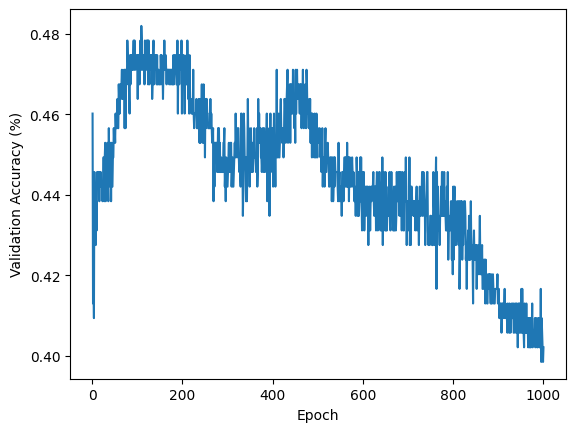

In [96]:
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.plot(np.linspace(1,1000,1000), history.history['val_accuracy'])

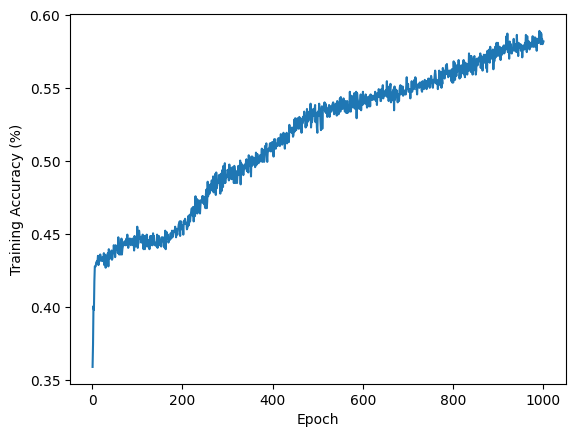

In [97]:
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy (%)")
plt.plot(np.linspace(1,1000,1000), history.history['accuracy'])

We'll also record the highest validation accuracy achieved by the model. The weights for this epoch were saved using the "early_stop" callback in the model fit. It is evident that the validation accuracy peaks before the model begins to overfit (training accuracy continues to increase while validation accuracy decreases). It is worth noting that there is a second peak in the validation accuracy that is slightly lower than the global peak which also corresponds to higher training accuracy (near epoch 500). Depending on the goal of the model, it could be worth investigating that point to see if it accurately predicts more results across the whole dataset. But for this experiment, we are interested in the global maximum.

In [98]:
print(max(history.history['val_accuracy']))

0.48188406229019165


It looks like we beat the book! An accuracy of 50% would guarantee a profit if we took the predicted outcome of each game. But even without that, there's a chance we could still beat the book. If we were betting people, and wagered one dollar on every game over the 8 season span, how much money would our model make and how much would the sportsbook "best" odds make?

In [99]:
yHat = model.predict(xNorm)

yHatmax = []

for i in range(len(yHat)):
  yHatmax.append(np.argmax(yHat[i]))

betOdds = np.asarray(xNorm[['B365A','B365D','B365H']])

betOddsmin = []

for i in range(len(betOdds)):
  betOddsmin.append(np.argmin(betOdds[i]))


odds = []
preds = []
both = []

for i in range(len(y)):
  if betOddsmin[i] == y[i]:
    odds.append(i)
  if yHatmax[i] == y[i]:
    preds.append(i)
  if (betOddsmin[i] == y[i]) & (yHatmax[i] == y[i]):
    both.append(i)

lines = np.asarray(dataNoFav[['B365A','B365D','B365H']])

betOddsBest = []

for i in range(len(lines)):
  betOddsBest.append(np.argmin(lines[i]))

winningsHat = 0
winningsBook = 0

for i in range(len(y)):
  if yHatmax[i] == y[i]:
    winningsHat+=lines[i][y[i]]
  if betOddsBest[i] == y[i]:
    winningsBook+=lines[i][y[i]]

print("The model won $", np.round(winningsHat - len(y), 2))
print("The book won $", np.round(winningsBook - len(y), 2))

44/44 [==============================] - 0s 2ms/step
The model won $ 697.61
The book won $ -68.37


We're positive! Of course, this is mostly down to luck. We happened to predict games with larger underdogs correctly and therefore made more than our accuracy in profit. But it was still a fun experiment to see if we could find value in the data.